# 08 线性回归模型从零开始的实现

这里只利用tensor和autograd来实现一个线性回归的训练

## 1.导入所需要的包

In [1]:
#%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

## 2.生成数据集

使用线性模型来生成数据集，生成一个1000个样本的数据集，下面是用来生成数据的线性关系：
$$ {\mathrm{y}} = w_{\mathrm{1}} \cdot x_{\mathrm{1}} + w_{\mathrm{2}} \cdot x_{\mathrm{2}} + b $$

In [2]:
# 设置输入的特征数量
num_inputs = 2
# 设置样本数量
num_examples = 1000

# 设置真实的权重和偏差以生成相应的标签
true_w = [2, -3.4]
true_b = 4.2

# 随机生成样本
features = torch.randn(num_examples, num_inputs,
                      dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
# 给标签加上无意义的干扰噪声
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)

## 3.使用图像来展示生成的数据

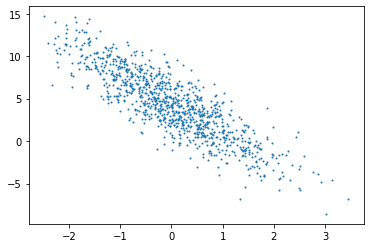

In [3]:
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

## 4.读取数据集
在训练模型时，我们需要遍历数据集并不断读取小批量数据样本。这里我们定义一个函数：它每次返回批量大小(batch_size)数量随机样本的特征和标签。

In [4]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)  # 传入的样本数量
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个完整的batch
        yield  features.index_select(0, j), labels.index_select(0, j)

我们读取第一个小批量样本数据并打印。

In [5]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.8197,  0.4944],
        [ 0.6858, -0.8615],
        [ 1.1705, -0.9048],
        [-0.2515, -1.3284],
        [-0.6791, -2.2315],
        [ 0.5284, -1.0820],
        [-0.2679, -0.7374],
        [ 0.6923,  0.9848],
        [ 0.6398,  2.1035],
        [-1.7033,  0.0114]]) 
 tensor([ 0.8667,  8.5071,  9.6380,  8.2207, 10.4333,  8.9452,  6.1703,  2.2323,
        -1.6851,  0.7626])


## 5.初始化模型参数

将权重初始化为均值为0，标准差为0.01的正态随机数，偏差则初始化为0。

In [6]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

由于之后的模型训练需要对这些参数求梯度来迭代参数的值，所以我们要让它们的requires_grad=True。

In [7]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

## 6.定义模型
定义用来训练参数的训练模型：
$$ {\mathrm{y}} = w_{\mathrm{1}} \cdot x_{\mathrm{1}} + w_{\mathrm{2}} \cdot x_{\mathrm{2}} + b $$

In [8]:
def linreg(X, w, b):
    return torch.mm(X, w) + b

## 7.定义损失函数
我们使用的是均方误差损失函数： $$ l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2, $$

In [9]:
def squared_loss(y_hat, y): 
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

## 8.定义优化函数
在这里优化函数使用的是小批量随机梯度下降：
$$ (\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b) $$
这里自动求梯度模块计算得到的梯度是一个批量样本的梯度和，我们将它除以批量大小来得到平均值。 

In [10]:
def sgd(params, lr, batch_size): 
    for param in params:
        param.data -= lr * param.grad / batch_size # ues.data可以在没有渐变轨迹的情况下操作参数

## 9.模型训练
当数据集、模型、损失函数和优化函数定义完了之后就可来准备进行模型的训练了。

In [11]:
# 超参数初始化
lr = 0.03  # 学习率
num_epochs = 5  # 迭代周期个数

net = linreg
loss = squared_loss

# 训练
for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每个周期，数据集中的所有样本将使用一次
    
    # X是特征，y是小批量样品的标签
    for X, y in data_iter(batch_size, features, labels):
        # 计算小批量样品损失的梯度
        l = loss(net(X, w, b), y).sum()
        
        # 小批量的损失对模型参数求梯度
        l.backward()
        
        # 使用小批量随机梯度下降迭代模型参数
        sgd([w, b], lr, batch_size)
        
        # 重置梯度参数，梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.033618
epoch 2, loss 0.000115
epoch 3, loss 0.000049
epoch 4, loss 0.000049
epoch 5, loss 0.000049


## 10.输出结果

In [12]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 2.0001],
        [-3.3997]], requires_grad=True)
4.2 
 tensor([4.1996], requires_grad=True)
